# Linear Regression Model 
### By Parth Agrawal (240905088) Team -2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load data
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Test.csv")

## Data Manipulation
All the null values and units have been removed with one hot encoding on non-numeric features

In [3]:
def preprocess_data(data):
    data = data.drop(['Unnamed: 0'], axis=1)
    #To implement one hot encoding using pandas, for the names of the cars, im using only the brand names of the cars. This code does that.
    for index, name in enumerate(data["Name"]):
        data.loc[index, "Name"] = str(data.loc[index, "Name"]).lower().split(" ")[0]
    
    data.Mileage = data.Mileage.str.replace(' kmpl' , '').astype(float)
    data.Engine = data.Engine.str.replace(' CC', '').astype(float)
    data['Power'] = data['Power'].replace('null bhp', '-1 bhp')
    data.Power = data.Power.str.replace(' bhp','').astype(float)
        
    for i in range(len(data["Power"])):
        if(data["Power"][i] == -1):
            data.drop(i, inplace=True) 
    # Convert categorical columns to lowercase and one-hot encode
    categorical_columns = ["Name", "Location", "Fuel_Type", "Transmission", "Owner_Type"]
    for col in categorical_columns:
        if col in data.columns:
            data[col] = data[col].astype(str).str.lower().str.split().str[0]
    data = pd.get_dummies(data, columns=categorical_columns, dtype=int)
    
    # Normalize numerical columns (after making sure there's no NaN left)
    numerical_columns = ["Year", "Mileage", "Engine", "Power", "Kilometers_Driven", "Seats"]
    for col in numerical_columns:
        if col in data.columns:
            # Make sure no NaN values are present before normalization
            data[col] = data[col].fillna(data[col].mean())  # Fill any remaining NaN values with the mean
            data[col] = (data[col] - data[col].mean()) / (data[col].std() + 0.01)
    
    # Final check for NaN values
    data = data.fillna(0)  # Ensure that there are no NaN values before returning the data
    
    return data

# Preprocess train and test datasets
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Align columns between train and test
train_data, test_data = train_data.align(test_data, join="outer", axis=1, fill_value=0)

train_data

,Engine,Fuel_Type_diesel,Fuel_Type_electric,Fuel_Type_petrol,Kilometers_Driven,Location_ahmedabad,Location_bangalore,Location_chennai,Location_coimbatore,Location_delhi,...,Owner_Type_first,Owner_Type_fourth,Owner_Type_second,Owner_Type_third,Power,Price,Seats,Transmission_automatic,Transmission_manual,Year
0,-0.712772,0,0,1,-1.023526,0,0,0,0,0,...,1,0,0,0,-0.547630,5.00,-0.348435,0,1,1.124079
1,-0.223269,1,0,0,-0.257706,0,0,0,0,0,...,1,0,0,0,-0.251510,8.37,2.104387,1,0,1.124079
2,-0.048446,0,0,1,-0.564386,0,0,0,0,0,...,1,0,0,0,-0.186364,4.50,-0.348435,0,1,0.184439
3,-0.384772,1,0,0,3.530642,0,0,0,0,0,...,0,0,1,0,-1.112107,0.85,-0.348435,0,1,-2.008057
4,-0.631188,1,0,0,0.155346,0,0,0,0,0,...,0,0,1,0,-0.459534,2.65,-0.348435,0,1,-0.128775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3745,2.274197,1,0,0,2.289724,0,0,1,0,0,...,1,0,0,0,2.246996,18.75,-0.348435,1,0,-1.381629
3746,0.918906,1,0,0,0.676531,0,0,0,0,1,...,1,0,0,0,0.118639,6.25,2.104387,1,0,-0.441989
3747,-1.047432,0,0,1,-0.065537,1,0,0,0,0,...,1,0,0,0,-0.860406,1.45,-0.348435,0,1,-2.008057
3748,-0.276548,1,0,0,0.490394,0,0,0,0,0,...,1,0,0,0,-0.551331,6.60,-0.348435,0,1,0.184439


In [4]:
# Initialize weights using Xavier initialization
def initialize_weights(features):
    return np.random.randn(features) * np.sqrt(2.0 / features)

# Cost function
def calculate_cost(X, y, weights, bias):
    n = X.shape[0]
    predictions = np.dot(X, weights) + bias
    cost = np.sum((predictions - y) ** 2) / (2 * n)
    return cost

# Gradient descent
def gradient_descent(X, y, weights, bias, learning_rate, iterations):
    n = X.shape[0]
    cost_history = []
    
    for i in range(iterations):
        predictions = np.dot(X, weights) + bias
        errors = predictions - y
        
        # Compute gradients
        dw = np.dot(X.T, errors) / n
        db = np.sum(errors) / n
        
        # Update weights and bias
        weights -= learning_rate * dw
        bias -= learning_rate * db
        
        # Calculate cost
        cost = calculate_cost(X, y, weights, bias)
        cost_history.append(cost)
        
        if i % 100 == 0:
            print(f"Iteration {i}: Cost = {cost}")
    
    return weights, bias, cost_history

# Predict function
def predict(X, weights, bias):
    return np.dot(X, weights) + bias

# R-squared function
def calculate_r2(X, y, weights, bias):
    predictions = predict(X, weights, bias)
    ss_total = np.sum((y - np.mean(y)) ** 2)
    ss_residual = np.sum((y - predictions) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

## Training the Model

In [5]:
# Separate features and target
X_train = train_data.drop(columns=["Price"]).values
y_train = train_data["Price"].values
X_test = test_data.drop(columns=["Price"]).values
y_test = test_data["Price"].values

# Initialize weights and bias
features = X_train.shape[1]
weights = initialize_weights(features)
bias = 0

# Hyperparameters
learning_rate = 0.1
iterations = 10000

# Train the model
weights, bias, cost_history = gradient_descent(X_train, y_train, weights, bias, learning_rate, iterations)

Iteration 0: Cost = 69.76950778468937
Iteration 100: Cost = 17.937946813404157
Iteration 200: Cost = 17.267282520947912
Iteration 300: Cost = 16.86155735671929
Iteration 400: Cost = 16.55979229149433
Iteration 500: Cost = 16.319134750696907
Iteration 600: Cost = 16.120589206401373
Iteration 700: Cost = 15.95364812957884
Iteration 800: Cost = 15.811628364376128
Iteration 900: Cost = 15.689839993212832
Iteration 1000: Cost = 15.584765679532095
Iteration 1100: Cost = 15.493652988206074
Iteration 1200: Cost = 15.41429043170996
Iteration 1300: Cost = 15.344871678171756
Iteration 1400: Cost = 15.28390562840548
Iteration 1500: Cost = 15.230152536186553
Iteration 1600: Cost = 15.182576259284938
Iteration 1700: Cost = 15.140307305800071
Iteration 1800: Cost = 15.102613566407296
Iteration 1900: Cost = 15.0688767742539
Iteration 2000: Cost = 15.038573372231358
Iteration 2100: Cost = 15.011258847457103
Iteration 2200: Cost = 14.986554835359861
Iteration 2300: Cost = 14.964138460064406
Iteration 24

## Accuracy Determination

In [6]:
# Evaluate the model
predictions = predict(X_test, weights, bias)
mse = np.mean((predictions - y_test) ** 2)
rmse = np.sqrt(mse)
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

# Calculate R-squared value
r2_score = calculate_r2(X_test, y_test, weights, bias)
print(f"R-squared: {r2_score}")

# Predict values for each car in the test set
predictions = predict(X_test, weights, bias)

# Print predicted and real values, along with percent error for each car
for i in range(len(y_test)):
    real_value = y_test[i]
    predicted_value = predictions[i]
    percent_error = abs((real_value - predicted_value) / real_value) * 100
    print(f"Car {i+1}: Real Price = {real_value}, Predicted Price = {predicted_value}, Percent Error = {percent_error:.2f}%")

Mean Squared Error: 30.566434210636505
Root Mean Squared Error: 5.528691907733375
R-squared: 0.7540343254342806
Car 1: Real Price = 6.95, Predicted Price = 5.583861341464124, Percent Error = 19.66%
Car 2: Real Price = 2.9, Predicted Price = 0.4272125963985296, Percent Error = 85.27%
Car 3: Real Price = 6.28, Predicted Price = 6.514788317832413, Percent Error = 3.74%
Car 4: Real Price = 13.8, Predicted Price = 19.718074597696496, Percent Error = 42.88%
Car 5: Real Price = 2.75, Predicted Price = 1.0703474331476839, Percent Error = 61.08%
Car 6: Real Price = 11.5, Predicted Price = 20.52671101243962, Percent Error = 78.49%
Car 7: Real Price = 5.1, Predicted Price = 5.441900773514362, Percent Error = 6.70%
Car 8: Real Price = 35.5, Predicted Price = 26.214982867827455, Percent Error = 26.15%
Car 9: Real Price = 50.5, Predicted Price = 44.16133483382203, Percent Error = 12.55%
Car 10: Real Price = 4.7, Predicted Price = 4.512023375646955, Percent Error = 4.00%
Car 11: Real Price = 2.6, Pre

## Graphing

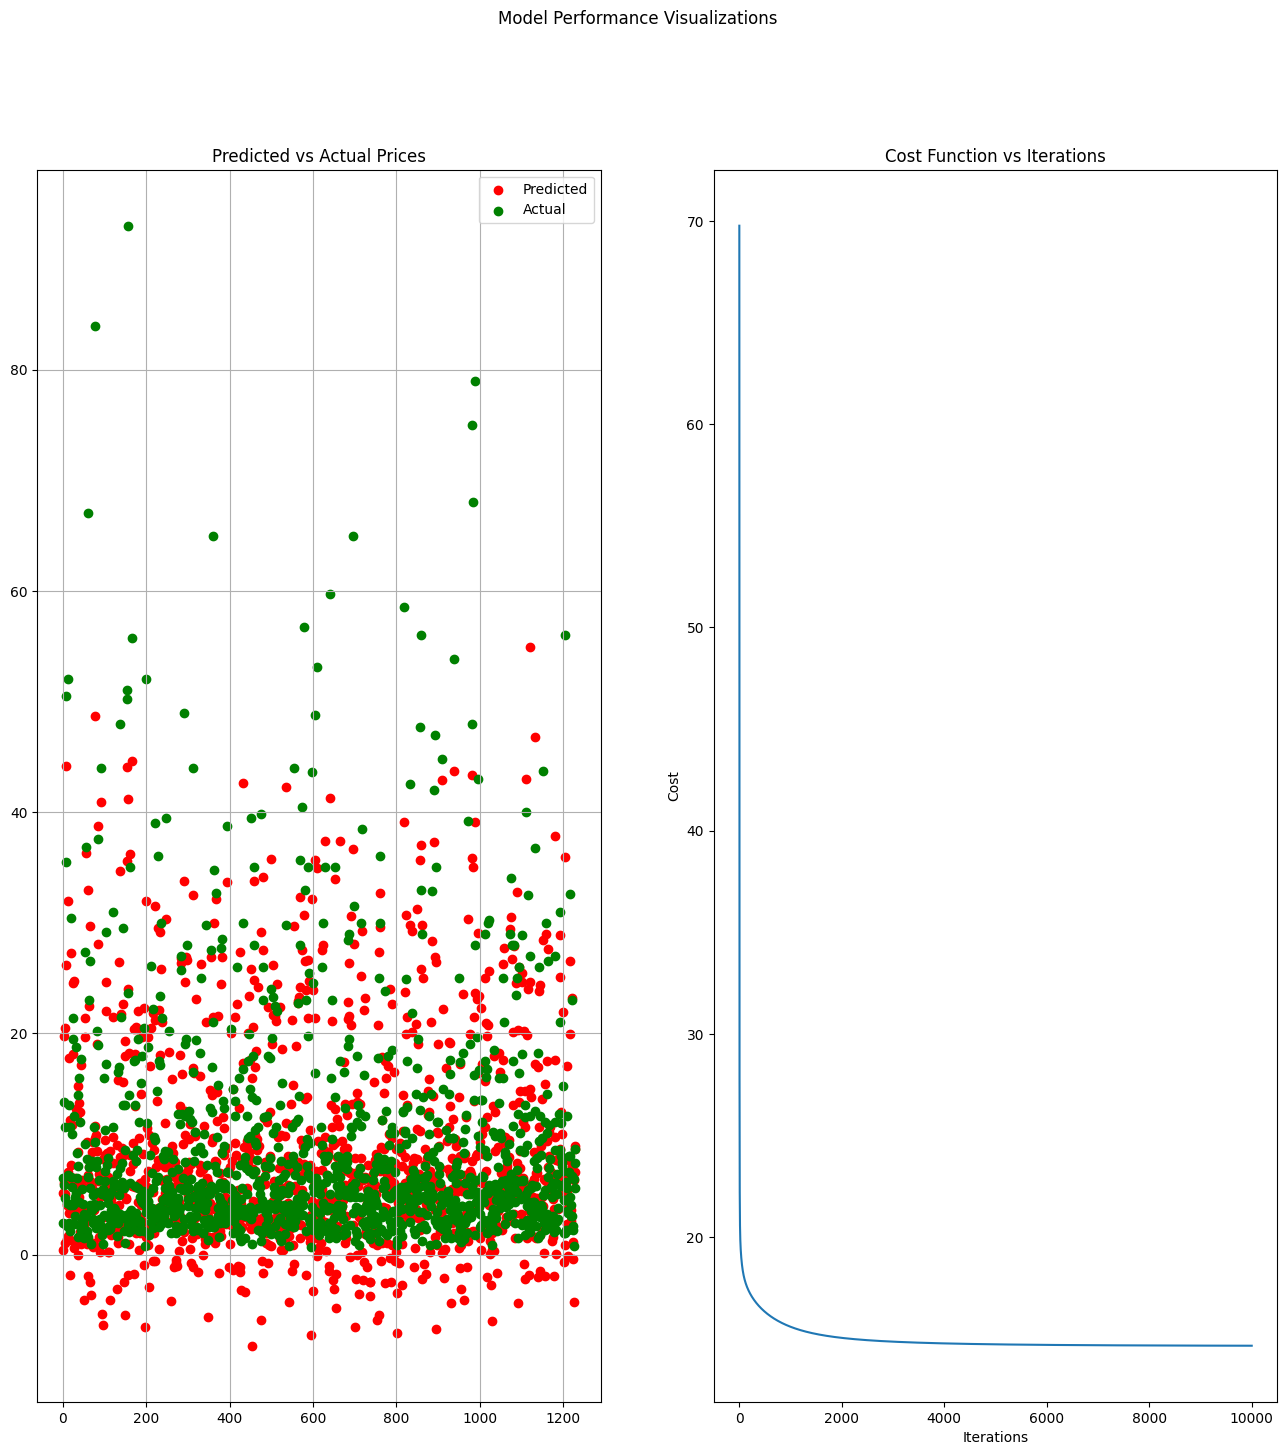

In [7]:
# Assuming the 'cost_history' contains the cost at each iteration from gradient descent
# Create a list to hold the errors (Mean Squared Error per iteration)
errs = [np.mean((np.dot(X_train, weights) + bias - y_train) ** 2) for _ in range(iterations)]

# Plotting
plt.rcParams['figure.figsize'] = [16, 16]
fig, (ax1, ax2) = plt.subplots(1, 2)

# First graph: Predicted values (red) vs Actual values (green)
ax1.scatter(range(len(predictions)), predictions, c='r', label="Predicted")
ax1.scatter(range(len(y_test)), y_test, c='g', label="Actual")
ax1.set_title("Predicted vs Actual Prices")
ax1.legend()
ax1.grid()

# Second graph: Cost Function (y) vs Iterations (x)
ax2.plot(range(len(cost_history)), cost_history)
ax2.set_title("Cost Function vs Iterations")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Cost")

# Overall title
plt.suptitle("Model Performance Visualizations")

# Show the plot
plt.show()
